<a href="https://colab.research.google.com/github/leshcsr/Reto3002b/blob/main/Deteccion_de_plagio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo
---




Construir un sistema de detección de plagio en código fuente utilizando técnicas de procesamiento de lenguaje natural (PLN), Word2Vec con Skip-gram y análisis de similaridad semántica mediante embeddings.

#Introducción
---
La detección de plagio en código fuente es un problema importante en educación y desarrollo de software. El objetivo es detectar cuándo un código ha sido copiado de otro código.
Utilizaremos embeddings, Word2Vec y modelos neuronales para capturar similitudes semánticas entre fragmentos de código.

**Flujo de trabajo**
1. Preprocesamiento del dataset
2. Word2Vec con arquitectura Skip-gram
3. Generación de embeddings
4. Modelo de clasificación

---
#Paso 1. Cargado y preprocesamiento del dataset (corpus)

Iniciamos cargando las librerías que vamos a necesitar.
Las de keras son para entrenar nuestro modelo que nos ayudará a saber si el código es plagio o no.





In [ ]:
!pip install javalang
!pip install --upgrade --force-reinstall numpy gensim

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp

In [ ]:
import javalang

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import pandas as pd
import os
import re

import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import tensorflow as tf
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential, load_model
import pickle

In [ ]:
from google.colab import drive
import pandas as pd

# Montar Google Drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/"

base_path = "/content/drive/MyDrive/Conplag_version_Dataset"

# Cargar dataset
labels_df = pd.read_csv(f"{base_path}/labels.csv")

print("Antes del balanceo:")
print(labels_df['verdict'].value_counts())

# Separar las clases
verdict_0 = labels_df[labels_df['verdict'] == 0]  # Mayoritaria: 660
verdict_1 = labels_df[labels_df['verdict'] == 1]  # Minoritaria: 251

# Submuestrear la clase mayoritaria (verdict 0) a 251 para balancear
verdict_0_sampled = verdict_0.sample(n=251, random_state=42)

# Imprimir las muestras submuestreadas de la clase 0
print("\nMuestras submuestreadas de la clase 0 (verdict=0):")
print(verdict_0_sampled)

# Combinar con la clase minoritaria completa (251 muestras)
balanced_labels_df = pd.concat([verdict_0_sampled, verdict_1], ignore_index=True)

# Barajar el dataset balanceado
balanced_labels_df = balanced_labels_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ Balanced dataset created with shape:", balanced_labels_df.shape)
print(balanced_labels_df['verdict'].value_counts())

labels_df = balanced_labels_df
print("\n✅dataset created with shape:", balanced_labels_df.shape)
print(labels_df['verdict'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
Antes del balanceo:
verdict
0    660
1    251
Name: count, dtype: int64

Muestras submuestreadas de la clase 0 (verdict=0):
         sub1      sub2  problem  verdict
872  18e2441c  792863db        9        0
687  b185d034  ccc8ef27       15        0
191  1410e423  da5cf40b        4        0
661  9be0602e  c4ca2ff3       15        0
135  9028caf7  a4e39423       19        0
..        ...       ...      ...      ...
324  d9199dfd  ff1fc018       20        0
319  93ee4612  da5cf40b        4        0
129  26e699de  e99c14b9        4        0
818  487c9f62  54488276       15        0
168  127af3a7  99ccaa44        3        0

[251 rows x 4 columns]

✅ Balanced dataset created with shape: (502, 4)
verdict
1    251
0    251
Name: count, dtype: int64

✅dataset created with shape: (502, 4)
verdict
1    251
0    251
Name: count, dtype: int64


In [ ]:
print("Etiquetas:")
print(labels_df.head())

print("\nTrain pairs:")
print(train_pairs_df.head())

print("\nTest pairs:")
print(test_pairs_df.head())

Etiquetas:
       sub1      sub2  problem  verdict
0  3d06b643  6bcc5afd       19        1
1  8535bdf7  e86eb5b0        1        0
2  034030f3  bf992c91       19        1
3  15941165  3b10bd6d       15        0
4  73f57af1  ac8ef97c        1        0

Train pairs:
   2470b521_f6ca6fc8
0  a8e2cefc_ee270b2a
1  90f01508_e00b1794
2  16857116_f3d7ce08
3  51151974_c23278ec
4  00f79486_ce0b2178

Test pairs:
   464a03b8_ff1fc018
0  3e6def38_548ffb07
1  213340b3_35f0c004
2  7bc92b7f_9028caf7
3  6f393cfe_b185d034
4  1dab88fb_bac616ee


El dataset que seleccionamos cuenta con la siguiente estructura:

directorio   ->   carpetas con los códigos fuentes nombradas con la pareja de ids de los códigos

Queremos enfocarnos en detectar el plagio desde la estructura y semántica del código, por lo tanto nuestra forma de preprocesar los datos será ignorar los comentarios, Tokenización básica y Normalización de identificadores para que esto no represente diferencias significativas para nuestro modelo.

In [ ]:
pre_compile = re.compile(r'//.*')
pre_compile2 = re.compile(r'/\*[\s\S]*?\*/')

def remove_comments(code):
    code = pre_compile.sub('', code)
    code = pre_compile2.sub('',code)
    return code

def remove_blank_lines(code):
    lines = code.splitlines()
    return "\n".join([line.strip() for line in lines if line.strip()])

def tokenize_with_javalang(code):
    try:
        tokens = list(javalang.tokenizer.tokenize(code))
        return [token.value for token in tokens]
    except Exception as e:
        print("Tokenization error:", e)
        return []

def normalize_identifiers(tokens):
    keywords = {
        'if', 'else', 'while', 'for', 'return', 'int', 'float',
        'double', 'String', 'public', 'private', 'protected', 'class',
        'void', 'static', 'new', 'import', 'package', 'boolean', 'true', 'false'
    }

    var_map = {}
    var_count = 1
    normalized = []

    for token in tokens:
        if token not in keywords and re.match(r'^[a-zA-Z_][a-zA-Z0-9_]*$', token):
            if token not in var_map:
                var_map[token] = f'VAR_{var_count}'
                var_count += 1
            normalized.append(var_map[token])
        else:
            normalized.append(token)
    return normalized

def preprocess_code(code):
    code = remove_comments(code)
    code = remove_blank_lines(code)
    tokens = tokenize_with_javalang(code)
    normalized_tokens = normalize_identifiers(tokens)
    return normalized_tokens

In [ ]:

def load_and_preprocess_code(base_path, pair_folder, submission_id):
    file_path = os.path.join(base_path, "version_2", pair_folder, f"{submission_id}.java")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        raw_code = f.read()
        tokens = preprocess_code(raw_code)
        return tokens

In [ ]:
def build_dataset(pair_df, labels_df, base_path):
    data = []
    for _, row in pair_df.iterrows():
        # DataFrame has columns 'sub1' and 'sub2'
        if 'sub1' in row and 'sub2' in row:
            sub1 = str(row['sub1'])
            sub2 = str(row['sub2'])
            pair_folder = f"{sub1}_{sub2}"
        else:
            # fallback for pair string like '123_456'
            pair_str = row[0]
            if '_' not in pair_str:
                continue
            sub1, sub2 = pair_str.split('_')
            pair_folder = f"{sub1}_{sub2}"

        # Load and preprocess code
        tokens1 = load_and_preprocess_code(base_path, pair_folder, sub1)
        tokens2 = load_and_preprocess_code(base_path, pair_folder, sub2)

        if tokens1 is None or tokens2 is None:
            continue

        # Attempt to find label
        label_row = labels_df[
          ((labels_df['sub1'].astype(str) == sub1) & (labels_df['sub2'].astype(str) == sub2)) |
          ((labels_df['sub1'].astype(str) == sub2) & (labels_df['sub2'].astype(str) == sub1))
        ]

        if not label_row.empty:
            label = int(label_row.iloc[0]['verdict'])
            data.append((tokens1, tokens2, label))
        else:
            # No label found, treat as unlabeled (e.g. test set)
            data.append((tokens1, tokens2, None))

    return data



In [ ]:
train_data = build_dataset(train_pairs_df, labels_df, base_path)
test_data = build_dataset(test_pairs_df, labels_df, base_path)

<ipython-input-41-2a6a66d12ea9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pair_str = row[0]
<ipython-input-41-2a6a66d12ea9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pair_str = row[0]
<ipython-input-41-2a6a66d12ea9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pair_str = row[0]
<ipython-input-41-2a6a66d12ea9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, int

In [ ]:

with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

print(os.path.getsize('train_data.pkl'))

812689


In [ ]:
with open('train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

---
#Paso 2. Entrenamiento de Word2vec con Skip-Gram


In [ ]:
all_tokens = [tokens for pair in train_data for tokens in pair[:2]]
all_tokens2 = [tokens for pair in test_data for tokens in pair[:2]]

all_tokens.extend(all_tokens2)
w2v_model = Word2Vec(sentences=all_tokens, vector_size=256, window=5, min_count=1, sg=5)

In [ ]:
w2v_model.train(all_tokens, total_examples=len(all_tokens), epochs=25)
sims = w2v_model.wv.most_similar('import', topn=10)
print(sims)
w2v_model.save("word2vec.model")

[('VAR_1', 0.9470529556274414), ('VAR_2', 0.8934987783432007), ('VAR_3', 0.7001855969429016), ('VAR_4', 0.5967070460319519), ('*', 0.5655975341796875), ('class', 0.5516318082809448), ('.', 0.5485557317733765), ('public', 0.5165324807167053), ('VAR_5', 0.4915902018547058), ('VAR_6', 0.47773611545562744)]


---
#Paso 3. Generación de embeddings para los pares

In [ ]:
w2v_model.wv.get_vector('import')

array([-0.4930815 ,  0.05898803,  0.19990762,  0.83351505,  0.42880085,
        0.07112657, -0.38225088, -0.48416463, -0.18822536,  0.43842676,
       -0.21978882, -0.34178922,  0.1083829 , -0.59849936, -0.1327053 ,
       -0.12879184,  0.37696487,  0.09756595, -0.17832541,  0.3971117 ,
       -0.04007574, -0.02864449, -0.02864737,  0.23305202, -0.23984136,
        0.5232    , -0.4137056 ,  0.3025495 , -0.2402531 , -0.05107754,
       -0.37087685,  0.16244139,  0.63017976,  0.21640432,  0.33039168,
       -0.6265572 , -0.2970675 ,  0.30620423, -0.02907081,  0.49138242,
        0.08265122, -0.44768673, -0.17973347, -0.5189981 , -0.48294488,
        0.26492324,  0.36133882,  0.19783087,  0.1733937 ,  0.10003084,
       -0.32759306,  0.07908894, -0.84824586, -0.4288499 , -0.39409804,
        0.16879858,  0.8159646 ,  0.3875101 ,  0.1855983 ,  0.3837441 ,
        0.22282097,  0.41786125,  1.0529307 ,  0.5284179 ,  0.19977285,
       -0.03107323, -0.17227702,  0.11544322, -0.34266397, -0.34

In [ ]:
def embed_code(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def prepare_dataset(data, model):
    X = []
    y = []

    for tokens1, tokens2, label in data:
        if label is None:   # Omitir pares sin etiqueta
            continue

        vec1 = embed_code(tokens1, model)
        vec2 = embed_code(tokens2, model)

        combined = np.concatenate([vec1, vec2, np.abs(vec1 - vec2)])

        X.append(combined)
        y.append(label)

    return np.array(X), np.array(y)



In [ ]:
X_train, y_train = prepare_dataset(train_data, w2v_model)
X_test, y_test = prepare_dataset(test_data, w2v_model)

In [ ]:
X_train

array([[ 0.04048276, -0.06218968,  0.01276802, ...,  0.01786145,
         0.00433577,  0.01608486],
       [ 0.02967936, -0.01437102, -0.01292332, ...,  0.00518636,
         0.00131756,  0.00108963],
       [ 0.03327683, -0.05328351,  0.0198249 , ...,  0.00962085,
         0.00234346,  0.01381573],
       ...,
       [-0.01422974, -0.03391634,  0.01636779, ...,  0.00171223,
         0.0029621 ,  0.02213022],
       [ 0.03870832, -0.06007032,  0.02029719, ...,  0.0293147 ,
         0.01788537,  0.00267182],
       [ 0.01590202, -0.05951782,  0.01476002, ...,  0.0100687 ,
         0.00080992,  0.00051487]], dtype=float32)

In [ ]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (127, 768), y_train shape: (127,)
X_test shape: (375, 768), y_test shape: (375,)


In [ ]:
input_dim = X_train.shape[1]

In [ ]:
model = Sequential([
    Dense(8, input_dim=input_dim, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=20,
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5489 - loss: 0.6929 - precision_2: 0.5489 - recall_2: 1.0000 - val_accuracy: 0.4960 - val_loss: 0.6929 - val_precision_2: 0.4960 - val_recall_2: 1.0000
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5133 - loss: 0.6921 - precision_2: 0.5133 - recall_2: 1.0000 - val_accuracy: 0.4960 - val_loss: 0.6924 - val_precision_2: 0.4960 - val_recall_2: 1.0000
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5158 - loss: 0.6911 - precision_2: 0.5158 - recall_2: 1.0000 - val_accuracy: 0.4960 - val_loss: 0.6918 - val_precision_2: 0.4960 - val_recall_2: 1.0000
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5276 - loss: 0.6900 - precision_2: 0.5276 - recall_2: 1.0000 - val_accuracy: 0.4960 - val_loss: 0.6915 - val_precision_2: 0.4960 - val_recall_2: 1.0000
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4795 - loss: 0.6915 - precision_2: 0.4795 - recall_2: 1.0000 - val_accuracy:

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión: {scores[1]*100:.2f}%")
print(f"Precisión: {scores[2]*100:.2f}% | Recall: {scores[3]*100:.2f}%")

model.save("plagio_detector.h5")


Precisión: 75.73%
Precisión: 82.76% | Recall: 64.52%


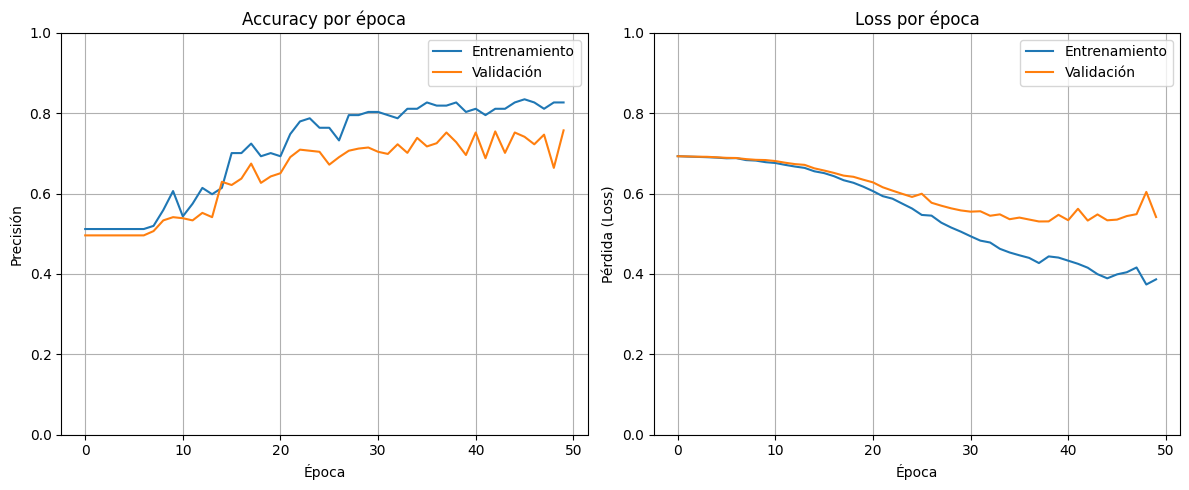

In [ ]:
# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Accuracy por época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.ylim(0,1)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Loss por época')
plt.xlabel('Época')
plt.ylabel('Pérdida (Loss)')
plt.ylim(0,1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(y_test, steps = 25)
print(f'\ntest ac  {test_acc:.4f}:\n')

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_2_1/Cast:0", shape=(15,), dtype=float32). Expected shape (None, 768), but input has incompatible shape (15,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(15,), dtype=int64)
  • training=False
  • mask=None

In [ ]:
print(classification_report(y_test, y_pred, target_names=["No Plagio", "Plagio"]))

NameError: name 'y_pred' is not defined

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


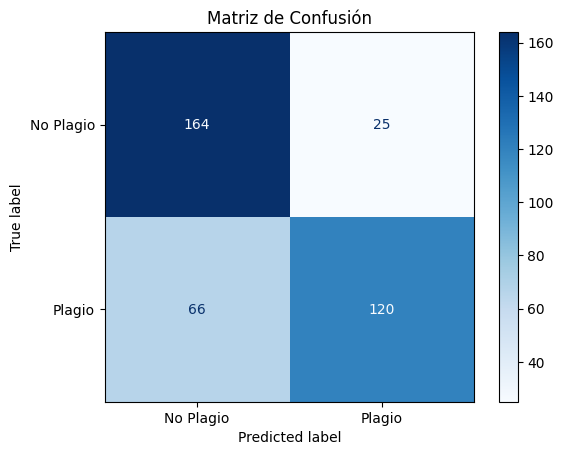

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Plagio", "Plagio"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.grid(False)
plt.show()


In [ ]:
class_names = ['No Plagio', 'Plagio']

---
#Paso 4. Detección del plagio

In [ ]:
w2v_model = Word2Vec.load("word2vec.model")
plagiarism_model = load_model("plagio_detector.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def prepare_pair_embedding(code1, code2, w2v_model):
    tokens1 = preprocess_code(code1)
    tokens2 = preprocess_code(code2)

    vec1 = embed_code(tokens1, w2v_model)
    vec2 = embed_code(tokens2, w2v_model)

    similarity = cosine_similarity([vec1], [vec2])[0][0]

    combined = np.concatenate([vec1, vec2, np.abs(vec1 - vec2)])
    features = combined.reshape(1, -1)

    prediction = model.predict(features)[0][0]

    print(f"\n Similitud coseno: {similarity:.4f}")
    print(f" Probabilidad (modelo) de plagio: {prediction:.4f}")

    if similarity < 0.366:
        print("Resultado: No hay plagio (baja similitud)")
    elif similarity < 0.566:
        print("Resultado: Posible similitud, pero no concluyente")
    else:
        print("Resultado: ¡Plagio detectado!")

    return combined.reshape(1, -1)

In [ ]:
def predict_plagiarism(code1, code2, model, w2v_model):
    features = prepare_pair_embedding(code1, code2, w2v_model)
    prediction = model.predict(features)[0][0]
    print(f"\nProbabilidad de plagio: {prediction:.4f}")
    certainty = 0.
    if prediction>0.566:
      print("Resultado: UPS! PLAGIO")
      certainty = float(np.absolute(prediction - 0.566)/0.434)
    else:
      print("Resultado: NO HAY PLAGIO")
      certainty = float(np.absolute(prediction - 0.566)/0.566)
    print(f"\Certeza del modelo: {certainty:.4f}")
    return prediction

In [ ]:
def main():

    while True:
        print("\n Sube dos archivos `.java` para comparar plagio")
        uploaded = files.upload()

        file_names = list(uploaded.keys())
        if len(file_names) != 2:
            print("Debes subir exactamente 2 archivos.")
            continue

        with open(file_names[0], 'r', encoding='utf-8', errors='ignore') as f1:
            code1 = f1.read()
        with open(file_names[1], 'r', encoding='utf-8', errors='ignore') as f2:
            code2 = f2.read()

        print(f"\n------ Archivo 1: {file_names[0]}")
        print(f"------ Archivo 2: {file_names[1]}")
        predict_plagiarism(code1, code2, plagiarism_model, w2v_model)

        print("\n¿Probar otros archivos? (s/n)")
        if input().strip().lower() != 's':
            break

main()


 Sube dos archivos `.java` para comparar plagio


Saving 464a03b8.java to 464a03b8.java
Saving ff1fc018.java to ff1fc018.java

------ Archivo 1: 464a03b8.java
------ Archivo 2: ff1fc018.java
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

 Similitud coseno: 0.9928
 Probabilidad (modelo) de plagio: 0.4991
Resultado: ¡Plagio detectado!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Probabilidad de plagio: 0.4991
Resultado: NO HAY PLAGIO
\Certeza del modelo: 0.1182

¿Probar otros archivos? (s/n)

 Sube dos archivos `.java` para comparar plagio


Saving 548ffb07.java to 548ffb07.java
Saving 3e6def38.java to 3e6def38.java

------ Archivo 1: 548ffb07.java
------ Archivo 2: 3e6def38.java
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

 Similitud coseno: 0.9967
 Probabilidad (modelo) de plagio: 0.7133
Resultado: ¡Plagio detectado!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Probabilidad de plagio: 0.7133
Resultado: UPS! PLAGIO
\Certeza del modelo: 0.3393

¿Probar otros archivos? (s/n)
